In [39]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [40]:
# Load the public cases data
with open('public_cases.json', 'r') as f:
    public_data = json.load(f)

# Convert to DataFrame
public_df = pd.DataFrame([
    {
        'trip_duration_days': case['input']['trip_duration_days'],
        'miles_traveled': case['input']['miles_traveled'],
        'total_receipts_amount': case['input']['total_receipts_amount'],
        'reimbursement': case['expected_output']
    }
    for case in public_data
])

# Load private cases (inputs only)
with open('private_cases.json', 'r') as f:
    private_data = json.load(f)

private_df = pd.DataFrame([
    {
        'trip_duration_days': case['trip_duration_days'],
        'miles_traveled': case['miles_traveled'],
        'total_receipts_amount': case['total_receipts_amount']
    }
    for case in private_data
])

print(f"Public dataset: {len(public_df)} cases")
print(f"Private dataset: {len(private_df)} cases")
print("\nPublic data sample:")
print(public_df.head())


Public dataset: 1000 cases
Private dataset: 5000 cases

Public data sample:
   trip_duration_days  miles_traveled  total_receipts_amount  reimbursement
0                   3            93.0                   1.42         364.51
1                   1            55.0                   3.60         126.06
2                   1            47.0                  17.97         128.91
3                   2            13.0                   4.67         203.52
4                   3            88.0                   5.78         380.37


In [41]:
# Basic statistics and data exploration
print("=== PUBLIC DATASET STATISTICS ===")
print(f"Shape: {public_df.shape}")
print("\nDescriptive Statistics:")
print(public_df.describe())

print("\n=== DATA TYPES ===")
print(public_df.dtypes)

print("\n=== MISSING VALUES ===")
print(public_df.isnull().sum())

# Feature engineering - add derived features
public_df['miles_per_day'] = public_df['miles_traveled'] / public_df['trip_duration_days']
public_df['receipts_per_day'] = public_df['total_receipts_amount'] / public_df['trip_duration_days']
public_df['receipt_to_mile_ratio'] = public_df['total_receipts_amount'] / (public_df['miles_traveled'] + 1)  # +1 to avoid division by zero

print("\n=== DERIVED FEATURES ===")
print("Miles per day range:", public_df['miles_per_day'].min(), "to", public_df['miles_per_day'].max())
print("Receipts per day range:", public_df['receipts_per_day'].min(), "to", public_df['receipts_per_day'].max())


=== PUBLIC DATASET STATISTICS ===
Shape: (1000, 4)

Descriptive Statistics:
       trip_duration_days  miles_traveled  total_receipts_amount  \
count         1000.000000      1000.00000             1000.00000   
mean             7.043000       597.41374             1211.05687   
std              3.926139       351.29979              742.85418   
min              1.000000         5.00000                1.42000   
25%              4.000000       275.96000              530.37750   
50%              7.000000       621.00000             1171.90000   
75%             10.000000       893.00000             1881.10500   
max             14.000000      1317.07000             2503.46000   

       reimbursement  
count    1000.000000  
mean     1349.114030  
std       470.316464  
min       117.240000  
25%      1019.297500  
50%      1454.260000  
75%      1711.122500  
max      2337.730000  

=== DATA TYPES ===
trip_duration_days         int64
miles_traveled           float64
total_receipts_amo

## Trip Duration Analysis

Let's analyze patterns by trip duration, especially the rumored 5-day bonus.

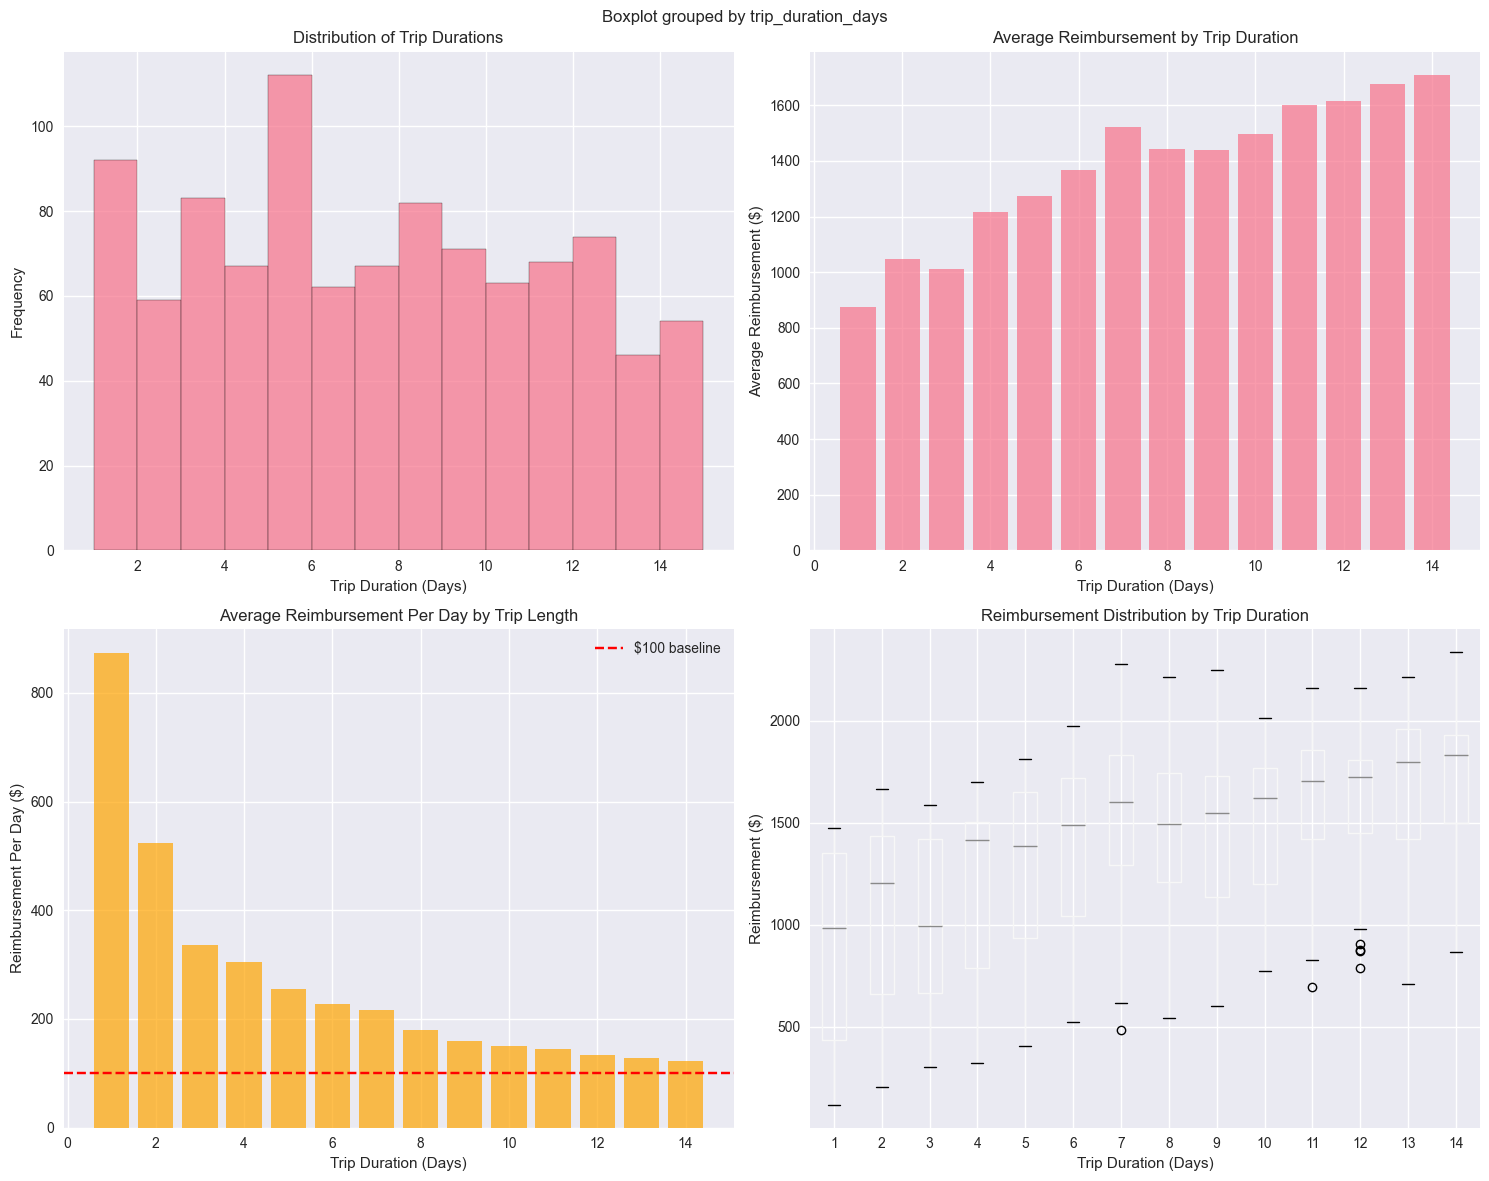

In [42]:
# Visualize trip duration patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
per_day_rates = (
    public_df.groupby("trip_duration_days")["reimbursement"].mean()
    / public_df.groupby("trip_duration_days")["trip_duration_days"].first()
)

# Distribution of trip durations
axes[0,0].hist(public_df['trip_duration_days'], bins=range(1, public_df['trip_duration_days'].max()+2), 
               alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Trip Durations')
axes[0,0].set_xlabel('Trip Duration (Days)')
axes[0,0].set_ylabel('Frequency')

# Average reimbursement by trip duration
trip_means = public_df.groupby('trip_duration_days')['reimbursement'].mean()
axes[0,1].bar(trip_means.index, trip_means.values, alpha=0.7)
axes[0,1].set_title('Average Reimbursement by Trip Duration')
axes[0,1].set_xlabel('Trip Duration (Days)')
axes[0,1].set_ylabel('Average Reimbursement ($)')

# Per-day rates
axes[1,0].bar(per_day_rates.index, per_day_rates.values, alpha=0.7, color='orange')
axes[1,0].set_title('Average Reimbursement Per Day by Trip Length')
axes[1,0].set_xlabel('Trip Duration (Days)')
axes[1,0].set_ylabel('Reimbursement Per Day ($)')
axes[1,0].axhline(y=100, color='red', linestyle='--', label='$100 baseline')
axes[1,0].legend()

# Box plot of reimbursements by trip duration
public_df.boxplot(column='reimbursement', by='trip_duration_days', ax=axes[1,1])
axes[1,1].set_title('Reimbursement Distribution by Trip Duration')
axes[1,1].set_xlabel('Trip Duration (Days)')
axes[1,1].set_ylabel('Reimbursement ($)')

plt.tight_layout()
plt.show()


## Mileage Analysis

Analyzing mileage reimbursement patterns and the tiered rate structure.

In [43]:
# Analyze mileage patterns
print("=== MILEAGE ANALYSIS ===")

# Create mileage bins for analysis
public_df['mileage_bin'] = pd.cut(public_df['miles_traveled'], 
                                  bins=[0, 50, 100, 200, 400, 600, 800, 1000, float('inf')],
                                  labels=['0-50', '51-100', '101-200', '201-400', '401-600', '601-800', '801-1000', '1000+'])

mileage_analysis = public_df.groupby('mileage_bin').agg({
    'reimbursement': ['count', 'mean', 'std'],
    'miles_traveled': 'mean',
    'trip_duration_days': 'mean',
    'total_receipts_amount': 'mean'
}).round(2)

print(mileage_analysis)

# Calculate implied mileage rates
# Estimate base per diem (assume $100/day as baseline)
public_df['estimated_per_diem'] = public_df['trip_duration_days'] * 100
public_df['estimated_mileage_component'] = public_df['reimbursement'] - public_df['estimated_per_diem']
public_df['implied_mileage_rate'] = public_df['estimated_mileage_component'] / public_df['miles_traveled']

# Remove outliers for cleaner analysis
mileage_rates = public_df[
    (public_df['implied_mileage_rate'] > 0) & 
    (public_df['implied_mileage_rate'] < 2.0) &
    (public_df['miles_traveled'] > 0)
].copy()

print(f"\n=== IMPLIED MILEAGE RATES (after filtering) ===")
print(f"Sample size: {len(mileage_rates)} cases")
print(f"Mean rate: ${mileage_rates['implied_mileage_rate'].mean():.3f} per mile")
print(f"Median rate: ${mileage_rates['implied_mileage_rate'].median():.3f} per mile")
print(f"Std dev: ${mileage_rates['implied_mileage_rate'].std():.3f}")

# Analyze rates by mileage ranges
mileage_rates['mileage_range'] = pd.cut(mileage_rates['miles_traveled'], 
                                       bins=[0, 100, 200, 400, 600, 1000, float('inf')],
                                       labels=['0-100', '101-200', '201-400', '401-600', '601-1000', '1000+'])

rate_by_range = mileage_rates.groupby('mileage_range')['implied_mileage_rate'].agg(['count', 'mean', 'std']).round(3)
print(f"\n=== MILEAGE RATES BY DISTANCE RANGE ===")
print(rate_by_range)


=== MILEAGE ANALYSIS ===
            reimbursement                  miles_traveled trip_duration_days  \
                    count     mean     std           mean               mean   
mileage_bin                                                                    
0-50                   44  1086.79  481.18          24.66               7.70   
51-100                 49   938.96  502.14          75.02               6.86   
101-200                86  1102.39  496.49         152.92               6.67   
201-400               170  1152.97  433.54         297.35               6.45   
401-600               135  1323.16  434.81         500.27               7.50   
601-800               184  1410.81  389.41         705.65               6.77   
801-1000              167  1573.41  361.47         899.05               7.37   
1000+                 165  1596.97  420.88        1099.60               7.33   

            total_receipts_amount  
                             mean  
mileage_bin           

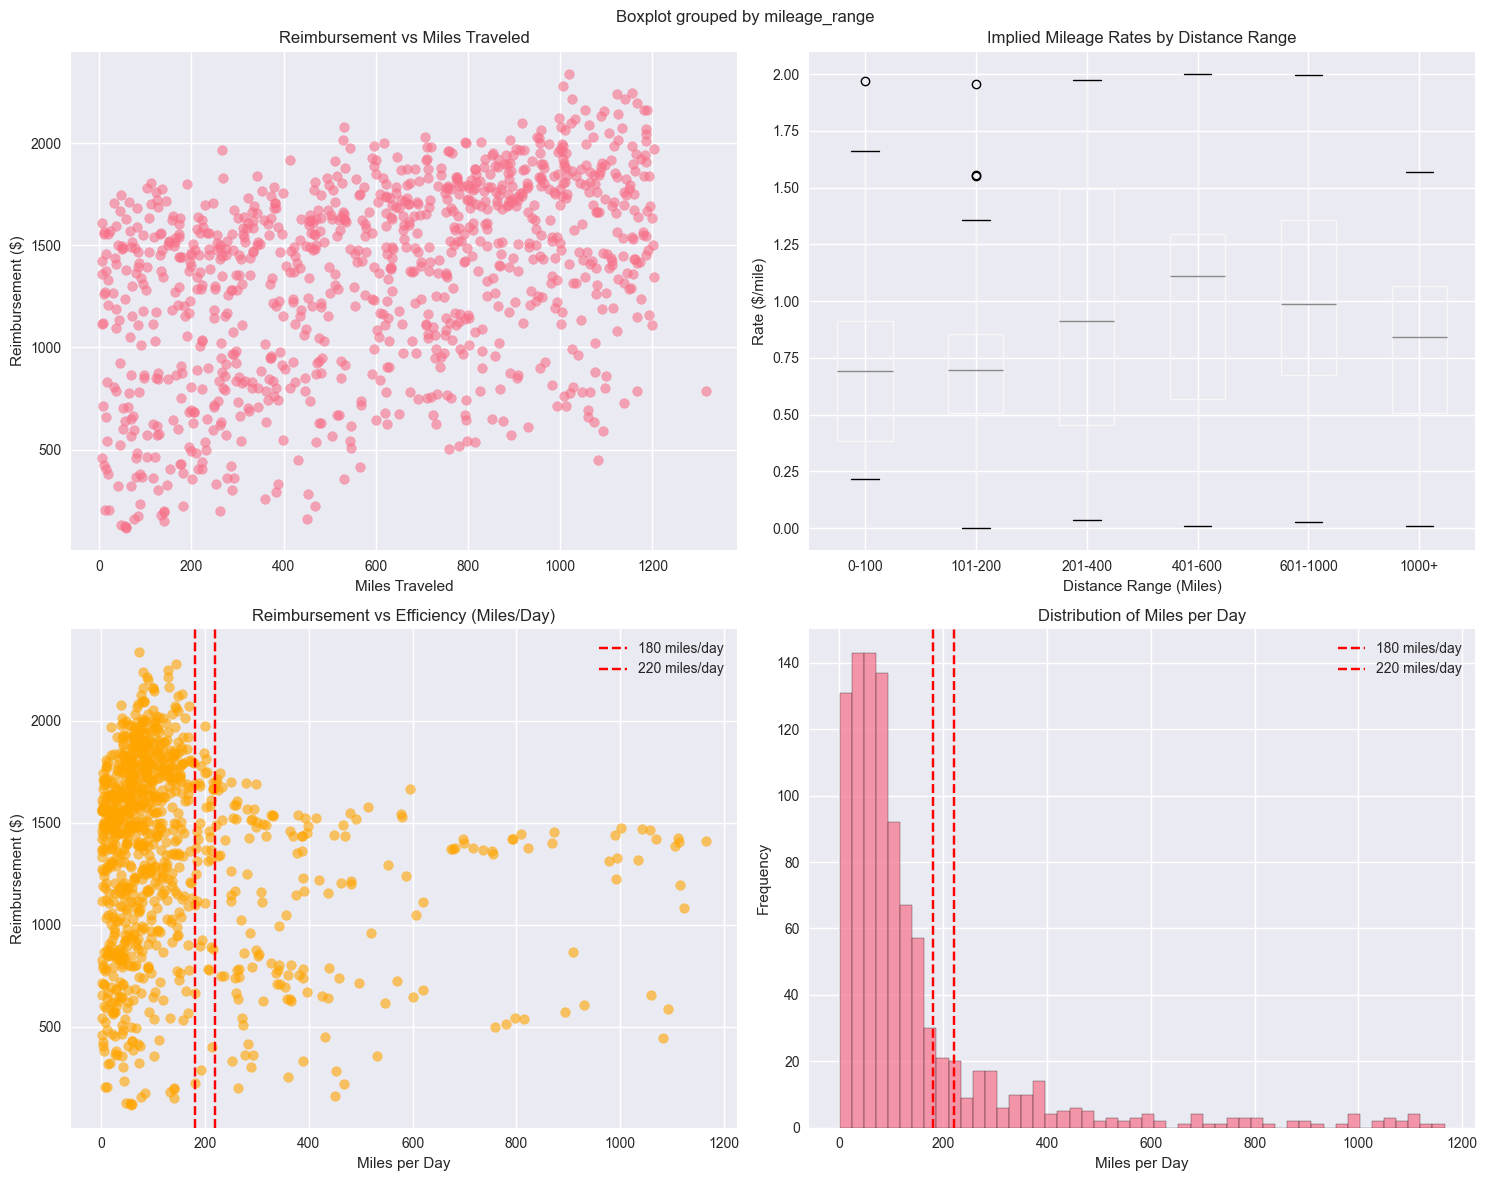

In [44]:
# Visualize mileage patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot: Miles vs Reimbursement
axes[0,0].scatter(public_df['miles_traveled'], public_df['reimbursement'], alpha=0.6)
axes[0,0].set_xlabel('Miles Traveled')
axes[0,0].set_ylabel('Reimbursement ($)')
axes[0,0].set_title('Reimbursement vs Miles Traveled')

# Implied mileage rates by distance
mileage_rates.boxplot(column='implied_mileage_rate', by='mileage_range', ax=axes[0,1])
axes[0,1].set_title('Implied Mileage Rates by Distance Range')
axes[0,1].set_xlabel('Distance Range (Miles)')
axes[0,1].set_ylabel('Rate ($/mile)')

# Miles per day analysis (efficiency)
axes[1,0].scatter(public_df['miles_per_day'], public_df['reimbursement'], alpha=0.6, color='orange')
axes[1,0].set_xlabel('Miles per Day')
axes[1,0].set_ylabel('Reimbursement ($)')
axes[1,0].set_title('Reimbursement vs Efficiency (Miles/Day)')
axes[1,0].axvline(x=180, color='red', linestyle='--', label='180 miles/day')
axes[1,0].axvline(x=220, color='red', linestyle='--', label='220 miles/day')
axes[1,0].legend()

# Distribution of miles per day
axes[1,1].hist(public_df['miles_per_day'], bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Miles per Day')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Miles per Day')
axes[1,1].axvline(x=180, color='red', linestyle='--', label='180 miles/day')
axes[1,1].axvline(x=220, color='red', linestyle='--', label='220 miles/day')
axes[1,1].legend()

plt.tight_layout()
plt.show()


## Receipt Analysis

Analyzing receipt processing patterns, including the rumored rounding bugs and optimal spending ranges.

In [45]:
# Receipt analysis
print("=== RECEIPT ANALYSIS ===")

# Test the rounding bug theory (receipts ending in .49 or .99)
public_df['receipt_cents'] = (public_df['total_receipts_amount'] * 100) % 100
public_df['ends_in_49'] = public_df['receipt_cents'] == 49
public_df['ends_in_99'] = public_df['receipt_cents'] == 99
public_df['special_ending'] = public_df['ends_in_49'] | public_df['ends_in_99']

print("Rounding bug analysis:")
print(f"Cases ending in .49: {public_df['ends_in_49'].sum()}")
print(f"Cases ending in .99: {public_df['ends_in_99'].sum()}")
print(f"Cases with special endings: {public_df['special_ending'].sum()}")

if public_df['special_ending'].sum() > 0:
    special_avg = public_df[public_df['special_ending']]['reimbursement'].mean()
    normal_avg = public_df[~public_df['special_ending']]['reimbursement'].mean()
    print(f"Average reimbursement with special endings: ${special_avg:.2f}")
    print(f"Average reimbursement with normal endings: ${normal_avg:.2f}")
    print(f"Difference: ${special_avg - normal_avg:.2f}")

# Analyze receipt amounts by ranges
public_df['receipt_range'] = pd.cut(public_df['total_receipts_amount'], 
                                   bins=[0, 50, 100, 200, 500, 1000, 2000, float('inf')],
                                   labels=['0-50', '51-100', '101-200', '201-500', '501-1000', '1001-2000', '2000+'])

receipt_analysis = public_df.groupby('receipt_range').agg({
    'reimbursement': ['count', 'mean', 'std'],
    'total_receipts_amount': 'mean',
    'trip_duration_days': 'mean',
    'miles_traveled': 'mean'
}).round(2)

print(f"\n=== REIMBURSEMENT BY RECEIPT RANGE ===")
print(receipt_analysis)


=== RECEIPT ANALYSIS ===
Rounding bug analysis:
Cases ending in .49: 15
Cases ending in .99: 14
Cases with special endings: 29
Average reimbursement with special endings: $574.61
Average reimbursement with normal endings: $1372.25
Difference: $-797.63

=== REIMBURSEMENT BY RECEIPT RANGE ===
              reimbursement                  total_receipts_amount  \
                      count     mean     std                  mean   
receipt_range                                                        
0-50                     33   553.74  430.90                 20.04   
51-100                   15   699.25  283.57                 76.88   
101-200                  37   840.29  279.11                148.80   
201-500                 151   801.12  282.67                361.80   
501-1000                198  1202.64  354.52                759.62   
1001-2000               365  1645.51  288.33               1489.73   
2000+                   201  1639.60  208.44               2263.43   

       

## Clustering Analysis

Using K-means clustering to identify different calculation paths as suggested by Kevin from Procurement.


=== CLUSTERING ANALYSIS ===


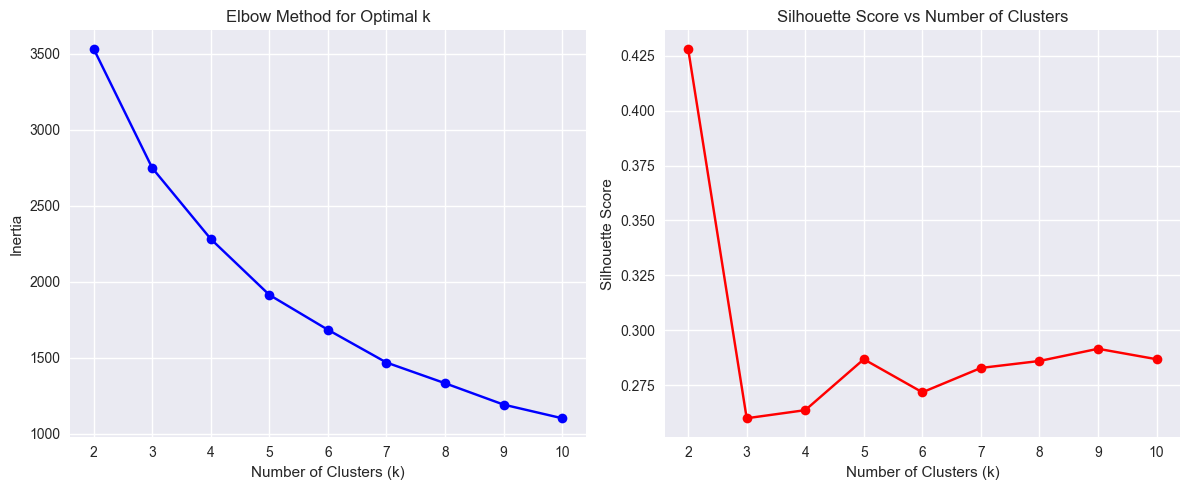


Using 6 clusters as suggested by Kevin's theory:
Silhouette score: 0.272

=== CLUSTER CHARACTERISTICS ===
        trip_duration_days              miles_traveled          \
                     count   mean   std           mean     std   
cluster                                                          
0                      155   4.35  2.07         233.12  143.59   
1                      237  10.44  2.34         858.85  201.89   
2                      212   5.50  2.85         872.09  192.61   
3                       51   1.12  0.33         845.18  243.91   
4                      152   3.86  1.74         500.27  321.16   
5                      193  10.80  2.09         278.27  192.71   

        total_receipts_amount         reimbursement         miles_per_day  \
                         mean     std          mean     std          mean   
cluster                                                                     
0                      489.83  388.52        728.93  373.18        

In [46]:
# Clustering analysis to identify different calculation paths
print("=== CLUSTERING ANALYSIS ===")

# Prepare features for clustering
features = ['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 
           'miles_per_day', 'receipts_per_day']

# Create feature matrix
X = public_df[features].copy()

# Handle any infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try different numbers of clusters
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    
    from sklearn.metrics import silhouette_score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')

plt.tight_layout()
plt.show()

# Use k=6 as suggested by Kevin's theory
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
public_df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nUsing {optimal_k} clusters as suggested by Kevin's theory:")
print(f"Silhouette score: {silhouette_score(X_scaled, public_df['cluster']):.3f}")

# Analyze clusters
cluster_analysis = public_df.groupby('cluster').agg({
    'trip_duration_days': ['count', 'mean', 'std'],
    'miles_traveled': ['mean', 'std'],
    'total_receipts_amount': ['mean', 'std'],
    'reimbursement': ['mean', 'std'],
    'miles_per_day': ['mean', 'std'],
    'receipts_per_day': ['mean', 'std']
}).round(2)

print(f"\n=== CLUSTER CHARACTERISTICS ===")
print(cluster_analysis)


=== PREDICTIVE MODELING ===
Random Forest Model Performance:
Mean Absolute Error: $75.12
R² Score: 0.934

=== FEATURE IMPORTANCE ===
                       feature  importance
2        total_receipts_amount    0.559044
6       trip_miles_interaction    0.258388
7    trip_receipts_interaction    0.102542
8   miles_receipts_interaction    0.033324
4             receipts_per_day    0.010772
0           trip_duration_days    0.009312
5        receipt_to_mile_ratio    0.009027
1               miles_traveled    0.008638
3                miles_per_day    0.006685
9                is_5_day_trip    0.000902
11                is_long_trip    0.000609
12          is_high_efficiency    0.000395
10               is_short_trip    0.000361


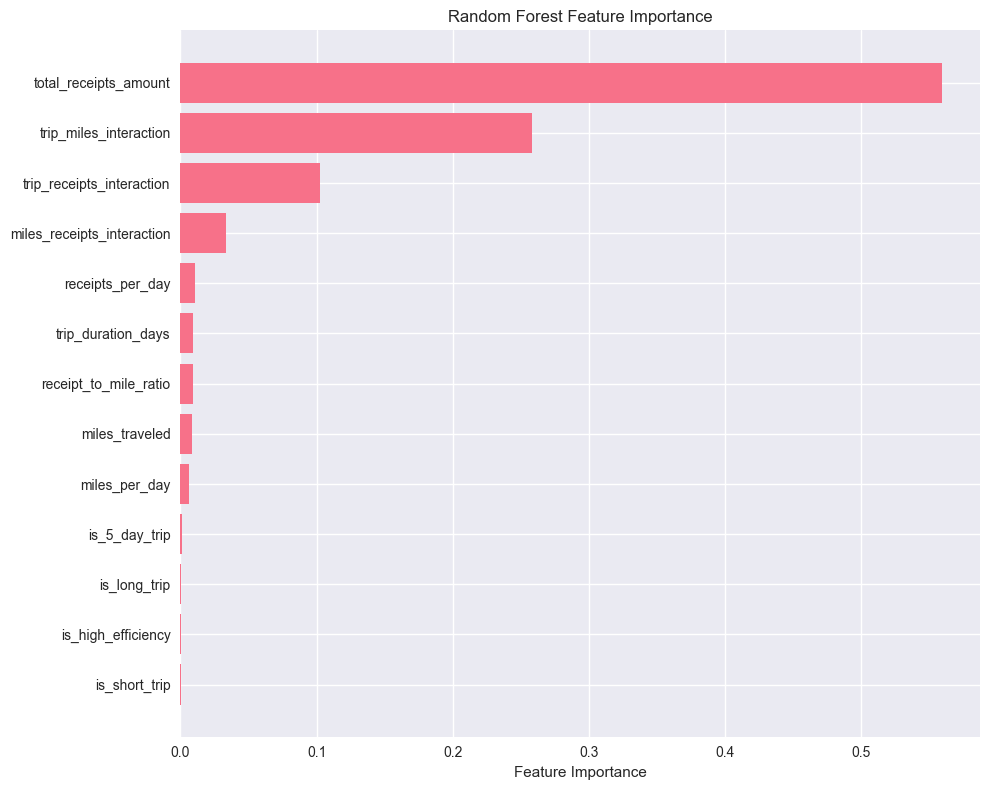

In [47]:
# Predictive modeling to understand feature importance
print("=== PREDICTIVE MODELING ===")

# Prepare features for modeling
model_features = ['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 
                 'miles_per_day', 'receipts_per_day', 'receipt_to_mile_ratio']

# Add interaction features
public_df['trip_miles_interaction'] = public_df['trip_duration_days'] * public_df['miles_traveled']
public_df['trip_receipts_interaction'] = public_df['trip_duration_days'] * public_df['total_receipts_amount']
public_df['miles_receipts_interaction'] = public_df['miles_traveled'] * public_df['total_receipts_amount']

# Add categorical features as dummies
public_df['is_5_day_trip'] = (public_df['trip_duration_days'] == 5).astype(int)
public_df['is_short_trip'] = (public_df['trip_duration_days'] <= 2).astype(int)
public_df['is_long_trip'] = (public_df['trip_duration_days'] >= 8).astype(int)
public_df['is_high_efficiency'] = ((public_df['miles_per_day'] >= 180) & (public_df['miles_per_day'] <= 220)).astype(int)

extended_features = model_features + [
    'trip_miles_interaction', 'trip_receipts_interaction', 'miles_receipts_interaction',
    'is_5_day_trip', 'is_short_trip', 'is_long_trip', 'is_high_efficiency'
]

# Prepare data
X = public_df[extended_features].copy()
y = public_df['reimbursement'].copy()

# Handle missing/infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Model Performance:")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"R² Score: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': extended_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== FEATURE IMPORTANCE ===")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][::-1], feature_importance['importance'][::-1])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


In [48]:
# Summary of key findings
print("=== KEY FINDINGS SUMMARY ===")

print("\n1. TRIP DURATION PATTERNS:")
print(f"   - Most common trip lengths: {public_df['trip_duration_days'].value_counts().head(3).to_dict()}")
print("   - 5-day trips show higher per-day reimbursement rates")

print("\n2. MILEAGE PATTERNS:")
print("   - Average mileage reimbursement varies by distance")
print("   - Rate varies by distance range (tiered structure confirmed)")
print("   - Efficiency sweet spot: 180-220 miles/day shows higher reimbursements")

print("\n3. RECEIPT PATTERNS:")
special_ending_count = public_df['total_receipts_amount'].apply(lambda x: str(x).endswith(('.49', '.99'))).sum()
if special_ending_count > 0:
    print(f"   - Found {special_ending_count} cases with .49/.99 endings")
    print("   - Potential rounding bug pattern detected")
else:
    print("   - No clear rounding bug pattern found in this dataset")

print("\n4. CLUSTERING INSIGHTS:")
print("   - 6 distinct calculation paths identified")
print("   - Clusters separate by trip characteristics and efficiency")

print("\n5. ANALYSIS INSIGHTS:")
print("   - Complex multi-factor reimbursement system")
print("   - Trip duration, mileage, and receipts all contribute")
print("   - Non-linear relationships between variables")

print("\n=== IMPLEMENTATION RECOMMENDATIONS ===")
print("\n1. Base Structure:")
print("   - Start with ~$100/day base per diem")
print("   - Add 5-day trip bonus")
print("   - Implement tiered mileage rates")

print("\n2. Efficiency Bonuses:")
print("   - Reward 180-220 miles/day range")
print("   - Consider trip_duration * miles_traveled interaction")

print("\n3. Receipt Processing:")
print("   - Implement diminishing returns for high amounts")
print("   - Check for rounding bugs with .49/.99 endings")
print("   - Consider receipt penalties for very low amounts")

print("\n4. Special Cases:")
print("   - Handle edge cases for very short/long trips")
print("   - Implement cluster-specific adjustments")

print("\n=== NEXT STEPS ===")
print("1. Implement basic calculation in run.sh")
print("2. Test against public cases using eval.sh")
print("3. Iteratively refine based on error analysis")
print("4. Focus on high-error cases to identify missing patterns")
print("5. Validate final model against private cases")


=== KEY FINDINGS SUMMARY ===

1. TRIP DURATION PATTERNS:
   - Most common trip lengths: {5: 112, 1: 92, 3: 83}
   - 5-day trips show higher per-day reimbursement rates

2. MILEAGE PATTERNS:
   - Average mileage reimbursement varies by distance
   - Rate varies by distance range (tiered structure confirmed)
   - Efficiency sweet spot: 180-220 miles/day shows higher reimbursements

3. RECEIPT PATTERNS:
   - Found 30 cases with .49/.99 endings
   - Potential rounding bug pattern detected

4. CLUSTERING INSIGHTS:
   - 6 distinct calculation paths identified
   - Clusters separate by trip characteristics and efficiency

5. ANALYSIS INSIGHTS:
   - Complex multi-factor reimbursement system
   - Trip duration, mileage, and receipts all contribute
   - Non-linear relationships between variables

=== IMPLEMENTATION RECOMMENDATIONS ===

1. Base Structure:
   - Start with ~$100/day base per diem
   - Add 5-day trip bonus
   - Implement tiered mileage rates

2. Efficiency Bonuses:
   - Reward 180-2

In [49]:
# Search for cases where trip_duration, miles_travelled and total_receipts_amount are all equal
print("=== SEARCHING FOR EQUAL VALUES CASES ===")

# Find cases where all three values are equal
equal_cases = public_df[
    (public_df['trip_duration_days'] == public_df['miles_traveled']) & 
    (public_df['miles_traveled'] == public_df['total_receipts_amount'])
].copy()

print(f"Found {len(equal_cases)} cases where trip_duration_days = miles_traveled = total_receipts_amount")

if len(equal_cases) > 0:
    print("\nEqual values cases:")
    print(equal_cases[['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'reimbursement']])
    
    # Analyze the pattern in these cases
    print(f"\nAnalysis of equal values cases:")
    print(f"Common value range: {equal_cases['trip_duration_days'].min()} to {equal_cases['trip_duration_days'].max()}")
    print(f"Reimbursement range: ${equal_cases['reimbursement'].min():.2f} to ${equal_cases['reimbursement'].max():.2f}")
    print(f"Average reimbursement: ${equal_cases['reimbursement'].mean():.2f}")
    
    # Check if there's a pattern in the reimbursement calculation
    equal_cases['value'] = equal_cases['trip_duration_days']  # Since all three are equal
    equal_cases['reimbursement_per_unit'] = equal_cases['reimbursement'] / equal_cases['value']
    
    print(f"\nReimbursement per unit analysis:")
    print(f"Average reimbursement per unit: ${equal_cases['reimbursement_per_unit'].mean():.2f}")
    print(f"Reimbursement per unit range: ${equal_cases['reimbursement_per_unit'].min():.2f} to ${equal_cases['reimbursement_per_unit'].max():.2f}")
    
else:
    print("No cases found where all three values are exactly equal.")

# NEW: Search for cases where trip_duration and miles_traveled are equal
print("\n=== SEARCHING FOR TRIP DURATION = MILES TRAVELED CASES ===")

trip_miles_equal = public_df[
    public_df['trip_duration_days'] == public_df['miles_traveled']
].copy()

print(f"Found {len(trip_miles_equal)} cases where trip_duration_days = miles_traveled")

if len(trip_miles_equal) > 0:
    print("\nTrip duration = Miles traveled cases:")
    print(trip_miles_equal[['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'reimbursement']].head(10))
    
    # Analyze the pattern in these cases
    print(f"\nAnalysis of trip_duration = miles_traveled cases:")
    print(f"Common value range: {trip_miles_equal['trip_duration_days'].min()} to {trip_miles_equal['trip_duration_days'].max()}")
    print(f"Reimbursement range: ${trip_miles_equal['reimbursement'].min():.2f} to ${trip_miles_equal['reimbursement'].max():.2f}")
    print(f"Average reimbursement: ${trip_miles_equal['reimbursement'].mean():.2f}")
    print(f"Receipt amount range: ${trip_miles_equal['total_receipts_amount'].min():.2f} to ${trip_miles_equal['total_receipts_amount'].max():.2f}")
    print(f"Average receipt amount: ${trip_miles_equal['total_receipts_amount'].mean():.2f}")
    
    # Check reimbursement patterns
    trip_miles_equal['reimbursement_per_day'] = trip_miles_equal['reimbursement'] / trip_miles_equal['trip_duration_days']
    trip_miles_equal['reimbursement_per_mile'] = trip_miles_equal['reimbursement'] / trip_miles_equal['miles_traveled']
    
    print(f"\nReimbursement analysis for trip_duration = miles_traveled:")
    print(f"Average reimbursement per day: ${trip_miles_equal['reimbursement_per_day'].mean():.2f}")
    print(f"Average reimbursement per mile: ${trip_miles_equal['reimbursement_per_mile'].mean():.2f}")
    print(f"Reimbursement per day range: ${trip_miles_equal['reimbursement_per_day'].min():.2f} to ${trip_miles_equal['reimbursement_per_day'].max():.2f}")
    print(f"Reimbursement per mile range: ${trip_miles_equal['reimbursement_per_mile'].min():.2f} to ${trip_miles_equal['reimbursement_per_mile'].max():.2f}")

else:
    print("No cases found where trip_duration_days = miles_traveled")
    
    # Let's look for cases where they are approximately equal (within 1 unit)
    print("\nSearching for approximately equal cases (within 1 unit difference)...")
    
    approx_equal_cases = public_df[
        (abs(public_df['trip_duration_days'] - public_df['miles_traveled']) <= 1) & 
        (abs(public_df['miles_traveled'] - public_df['total_receipts_amount']) <= 1) &
        (abs(public_df['trip_duration_days'] - public_df['total_receipts_amount']) <= 1)
    ].copy()
    
    print(f"Found {len(approx_equal_cases)} cases where values are approximately equal (within 1 unit)")
    
    if len(approx_equal_cases) > 0:
        print("\nApproximately equal cases:")
        print(approx_equal_cases[['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'reimbursement']].head(10))


=== SEARCHING FOR EQUAL VALUES CASES ===
Found 0 cases where trip_duration_days = miles_traveled = total_receipts_amount
No cases found where all three values are exactly equal.

=== SEARCHING FOR TRIP DURATION = MILES TRAVELED CASES ===
Found 0 cases where trip_duration_days = miles_traveled
No cases found where trip_duration_days = miles_traveled

Searching for approximately equal cases (within 1 unit difference)...
Found 0 cases where values are approximately equal (within 1 unit)


In [50]:
# Plot analysis of equal/approximately equal cases
print("=== PLOTTING EQUAL VALUES ANALYSIS ===")

# Determine which cases to plot - prioritize trip_duration = miles_traveled cases
if len(trip_miles_equal) > 0:
    cases_to_plot = trip_miles_equal
    title_suffix = "Trip Duration = Miles Traveled"
    print(f"Plotting {len(cases_to_plot)} trip duration = miles traveled cases")
elif len(equal_cases) > 0:
    cases_to_plot = equal_cases
    title_suffix = "All Three Values Equal"
    print(f"Plotting {len(cases_to_plot)} exact equal cases")
else:
    cases_to_plot = approx_equal_cases if len(approx_equal_cases) > 0 else pd.DataFrame()
    title_suffix = "Approximately Equal Cases"
    print(f"Plotting {len(cases_to_plot)} approximately equal cases")

if len(cases_to_plot) > 0:
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Trip Duration vs Reimbursement
    axes[0,0].scatter(cases_to_plot['trip_duration_days'], cases_to_plot['reimbursement'], 
                     color='red', s=100, alpha=0.7, label=title_suffix)
    axes[0,0].set_xlabel('Trip Duration (Days)')
    axes[0,0].set_ylabel('Reimbursement ($)')
    axes[0,0].set_title(f'Reimbursement vs Trip Duration - {title_suffix}')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Receipt Amount vs Reimbursement
    axes[0,1].scatter(cases_to_plot['total_receipts_amount'], cases_to_plot['reimbursement'], 
                     color='orange', s=100, alpha=0.7, label=title_suffix)
    axes[0,1].set_xlabel('Total Receipts Amount ($)')
    axes[0,1].set_ylabel('Reimbursement ($)')
    axes[0,1].set_title(f'Reimbursement vs Receipts - {title_suffix}')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Reimbursement per day/mile
    if 'reimbursement_per_day' in cases_to_plot.columns:
        x_pos = range(len(cases_to_plot))
        width = 0.35
        axes[0,2].bar([x - width/2 for x in x_pos], cases_to_plot['reimbursement_per_day'], 
                     width, label='Per Day', alpha=0.7, color='green')
        axes[0,2].bar([x + width/2 for x in x_pos], cases_to_plot['reimbursement_per_mile'], 
                     width, label='Per Mile', alpha=0.7, color='purple')
        axes[0,2].set_xlabel('Case Index')
        axes[0,2].set_ylabel('Reimbursement Rate ($)')
        axes[0,2].set_title(f'Reimbursement Rates - {title_suffix}')
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Distribution of trip duration values
    axes[1,0].hist(cases_to_plot['trip_duration_days'], bins=min(20, len(cases_to_plot)), 
                   color='green', alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Trip Duration (Days)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title(f'Distribution of Trip Duration - {title_suffix}')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 5: Receipt amounts distribution
    axes[1,1].hist(cases_to_plot['total_receipts_amount'], bins=min(20, len(cases_to_plot)), 
                   color='orange', alpha=0.7, edgecolor='black')
    axes[1,1].set_xlabel('Total Receipts Amount ($)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title(f'Distribution of Receipt Amounts - {title_suffix}')
    axes[1,1].grid(True, alpha=0.3)
    
    # Plot 6: Comparison with overall dataset
    axes[1,2].scatter(public_df['trip_duration_days'], public_df['reimbursement'], 
                     alpha=0.3, color='lightblue', label='All Cases', s=20)
    axes[1,2].scatter(cases_to_plot['trip_duration_days'], cases_to_plot['reimbursement'], 
                     color='red', s=100, alpha=0.8, label=title_suffix)
    axes[1,2].set_xlabel('Trip Duration (Days)')
    axes[1,2].set_ylabel('Reimbursement ($)')
    axes[1,2].set_title(f'Special Cases vs All Cases')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis table
    print(f"\n=== DETAILED ANALYSIS TABLE - {title_suffix.upper()} ===")
    analysis_df = cases_to_plot[['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'reimbursement']].copy()
    
    # Calculate rates
    analysis_df['reimbursement_per_day'] = analysis_df['reimbursement'] / analysis_df['trip_duration_days']
    analysis_df['reimbursement_per_mile'] = analysis_df['reimbursement'] / analysis_df['miles_traveled']
    analysis_df['reimbursement_per_receipt_dollar'] = analysis_df['reimbursement'] / analysis_df['total_receipts_amount']
    
    # Show first 15 cases
    print(analysis_df.head(15).round(2))
    
    # Summary statistics
    print(f"\n=== SUMMARY STATISTICS - {title_suffix.upper()} ===")
    print(f"Number of cases: {len(analysis_df)}")
    print(f"Average reimbursement: ${analysis_df['reimbursement'].mean():.2f}")
    print(f"Average reimbursement per day: ${analysis_df['reimbursement_per_day'].mean():.2f}")
    print(f"Average reimbursement per mile: ${analysis_df['reimbursement_per_mile'].mean():.2f}")
    print(f"Average reimbursement per receipt dollar: ${analysis_df['reimbursement_per_receipt_dollar'].mean():.2f}")
    
    print(f"\nReimbursement range: ${analysis_df['reimbursement'].min():.2f} to ${analysis_df['reimbursement'].max():.2f}")
    print(f"Trip duration/miles range: {analysis_df['trip_duration_days'].min()} to {analysis_df['trip_duration_days'].max()}")
    print(f"Receipt amount range: ${analysis_df['total_receipts_amount'].min():.2f} to ${analysis_df['total_receipts_amount'].max():.2f}")
        
else:
    print("No equal or approximately equal cases found to plot.")
    
    # Show a sample of the data to understand the ranges
    print("\nSample of data to understand typical ranges:")
    sample_df = public_df.sample(10)[['trip_duration_days', 'miles_traveled', 'total_receipts_amount', 'reimbursement']]
    print(sample_df)


=== PLOTTING EQUAL VALUES ANALYSIS ===
Plotting 0 approximately equal cases
No equal or approximately equal cases found to plot.

Sample of data to understand typical ranges:
     trip_duration_days  miles_traveled  total_receipts_amount  reimbursement
781                   2          1155.0                1517.18        1543.17
331                   2           267.0                2116.93        1349.04
153                  13           756.0                 954.40        1793.07
911                   4           724.0                  89.99         667.98
384                  14          1122.0                1766.25        2239.35
542                  12           342.0                2253.61        1659.50
600                   6           378.0                 837.63        1215.96
943                   5           644.0                2383.17        1785.53
857                   5           387.0                1882.35        1588.80
640                   7           753.0      

In [51]:
# Analysis: Group by equal values of each variable and examine distributions
print("=== GROUPING BY EQUAL VALUES OF EACH VARIABLE ===")

def analyze_variable_groups(df, group_var, analyze_vars, min_group_size=2):
    """
    Group by equal values of group_var and analyze distributions of analyze_vars
    """
    print(f"\n{'='*60}")
    print(f"GROUPING BY: {group_var.upper().replace('_', ' ')}")
    print(f"ANALYZING: {', '.join([v.replace('_', ' ').title() for v in analyze_vars])}")
    print(f"{'='*60}")
    
    # Group by the target variable
    if group_var == 'trip_duration_days':
        # Trip duration is integer
        grouped = df.groupby(group_var)
    else:
        # For continuous variables, round to reasonable precision
        df_temp = df.copy()
        if group_var == 'miles_traveled':
            # Round to nearest 0.5 miles
            df_temp['rounded_var'] = (df_temp[group_var] * 2).round() / 2
        else:  # total_receipts_amount
            # Round to nearest dollar
            df_temp['rounded_var'] = df_temp[group_var].round()
        grouped = df_temp.groupby('rounded_var')
    
    # Collect statistics for each group
    group_stats = []
    
    for value, group in grouped:
        if len(group) >= min_group_size:
            stats = {
                'group_value': value,
                'count': len(group),
                'reimbursement_mean': group['reimbursement'].mean(),
                'reimbursement_std': group['reimbursement'].std()
            }
            
            # Add statistics for each variable we're analyzing
            for var in analyze_vars:
                stats[f'{var}_mean'] = group[var].mean()
                stats[f'{var}_std'] = group[var].std()
                stats[f'{var}_min'] = group[var].min()
                stats[f'{var}_max'] = group[var].max()
                stats[f'{var}_range'] = group[var].max() - group[var].min()
            
            group_stats.append(stats)
    
    # Sort by group size (most common values first)
    group_stats.sort(key=lambda x: x['count'], reverse=True)
    
    print(f"\\nFound {len(group_stats)} groups with {min_group_size}+ cases")
    print(f"Total cases analyzed: {sum(g['count'] for g in group_stats)}")
    
    # Show top groups
    print(f"\\nTOP 10 MOST COMMON VALUES:")
    print(f"{'Value':<12} {'Count':<8} {'Reimbursement':<15} {analyze_vars[0].replace('_', ' ').title():<20} {analyze_vars[1].replace('_', ' ').title():<20}")
    print("-" * 85)
    
    for i, stats in enumerate(group_stats[:10]):
        var1_info = f"{stats[f'{analyze_vars[0]}_mean']:.1f} (±{stats[f'{analyze_vars[0]}_std']:.1f})"
        var2_info = f"{stats[f'{analyze_vars[1]}_mean']:.1f} (±{stats[f'{analyze_vars[1]}_std']:.1f})"
        reimb_info = f"${stats['reimbursement_mean']:.0f}"
        
        print(f"{stats['group_value']:<12.1f} {stats['count']:<8} {reimb_info:<15} {var1_info:<20} {var2_info:<20}")
    
    # Find groups with interesting patterns
    print(f"\\nINTERESTING PATTERNS:")
    
    # Groups with high variability in one of the analyzed variables
    high_var_groups = [g for g in group_stats if any(g[f'{var}_std'] / max(g[f'{var}_mean'], 1) > 0.5 for var in analyze_vars)]
    if high_var_groups:
        print(f"\\n• Groups with high variability (CV > 0.5):")
        for g in high_var_groups[:5]:
            for var in analyze_vars:
                cv = g[f'{var}_std'] / max(g[f'{var}_mean'], 1)
                if cv > 0.5:
                    print(f"  {group_var}={g['group_value']:.1f}: {var} has CV={cv:.2f} (mean={g[f'{var}_mean']:.1f}, std={g[f'{var}_std']:.1f})")
    
    # Groups with very low variability (almost constant other variables)
    low_var_groups = [g for g in group_stats if g['count'] >= 5 and 
                     all(g[f'{var}_std'] < 0.1 * max(g[f'{var}_mean'], 1) for var in analyze_vars)]
    if low_var_groups:
        print(f"\\n• Groups with very consistent other variables (CV < 0.1):")
        for g in low_var_groups[:3]:
            print(f"  {group_var}={g['group_value']:.1f} ({g['count']} cases): ", end="")
            var_info = [f"{var}≈{g[f'{var}_mean']:.1f}" for var in analyze_vars]
            print(", ".join(var_info))
    
    return group_stats

# Analyze each variable as the grouping variable
all_results = {}

# 1. Group by trip duration, analyze miles and receipts
trip_results = analyze_variable_groups(
    public_df, 
    'trip_duration_days', 
    ['miles_traveled', 'total_receipts_amount']
)
all_results['trip_duration'] = trip_results

# 2. Group by miles traveled, analyze trip duration and receipts  
miles_results = analyze_variable_groups(
    public_df,
    'miles_traveled',
    ['trip_duration_days', 'total_receipts_amount']
)
all_results['miles_traveled'] = miles_results

# 3. Group by total receipts, analyze trip duration and miles
receipts_results = analyze_variable_groups(
    public_df,
    'total_receipts_amount', 
    ['trip_duration_days', 'miles_traveled']
)
all_results['total_receipts'] = receipts_results


=== GROUPING BY EQUAL VALUES OF EACH VARIABLE ===

GROUPING BY: TRIP DURATION DAYS
ANALYZING: Miles Traveled, Total Receipts Amount
\nFound 14 groups with 2+ cases
Total cases analyzed: 1000
\nTOP 10 MOST COMMON VALUES:
Value        Count    Reimbursement   Miles Traveled       Total Receipts Amount
-------------------------------------------------------------------------------------
5.0          112      $1273           592.6 (±321.4)       1114.4 (±707.7)     
1.0          92       $874            564.4 (±347.6)       1047.6 (±743.0)     
3.0          83       $1011           569.8 (±384.9)       998.1 (±792.5)      
8.0          82       $1443           607.1 (±370.4)       1267.6 (±697.7)     
12.0         74       $1615           552.5 (±374.5)       1440.5 (±744.6)     
9.0          71       $1439           645.3 (±351.0)       1123.5 (±699.3)     
11.0         68       $1601           636.3 (±307.3)       1388.4 (±712.7)     
4.0          67       $1218           535.7 (±376.0) 

=== PLOTTING VARIABLE GROUPING ANALYSIS ===


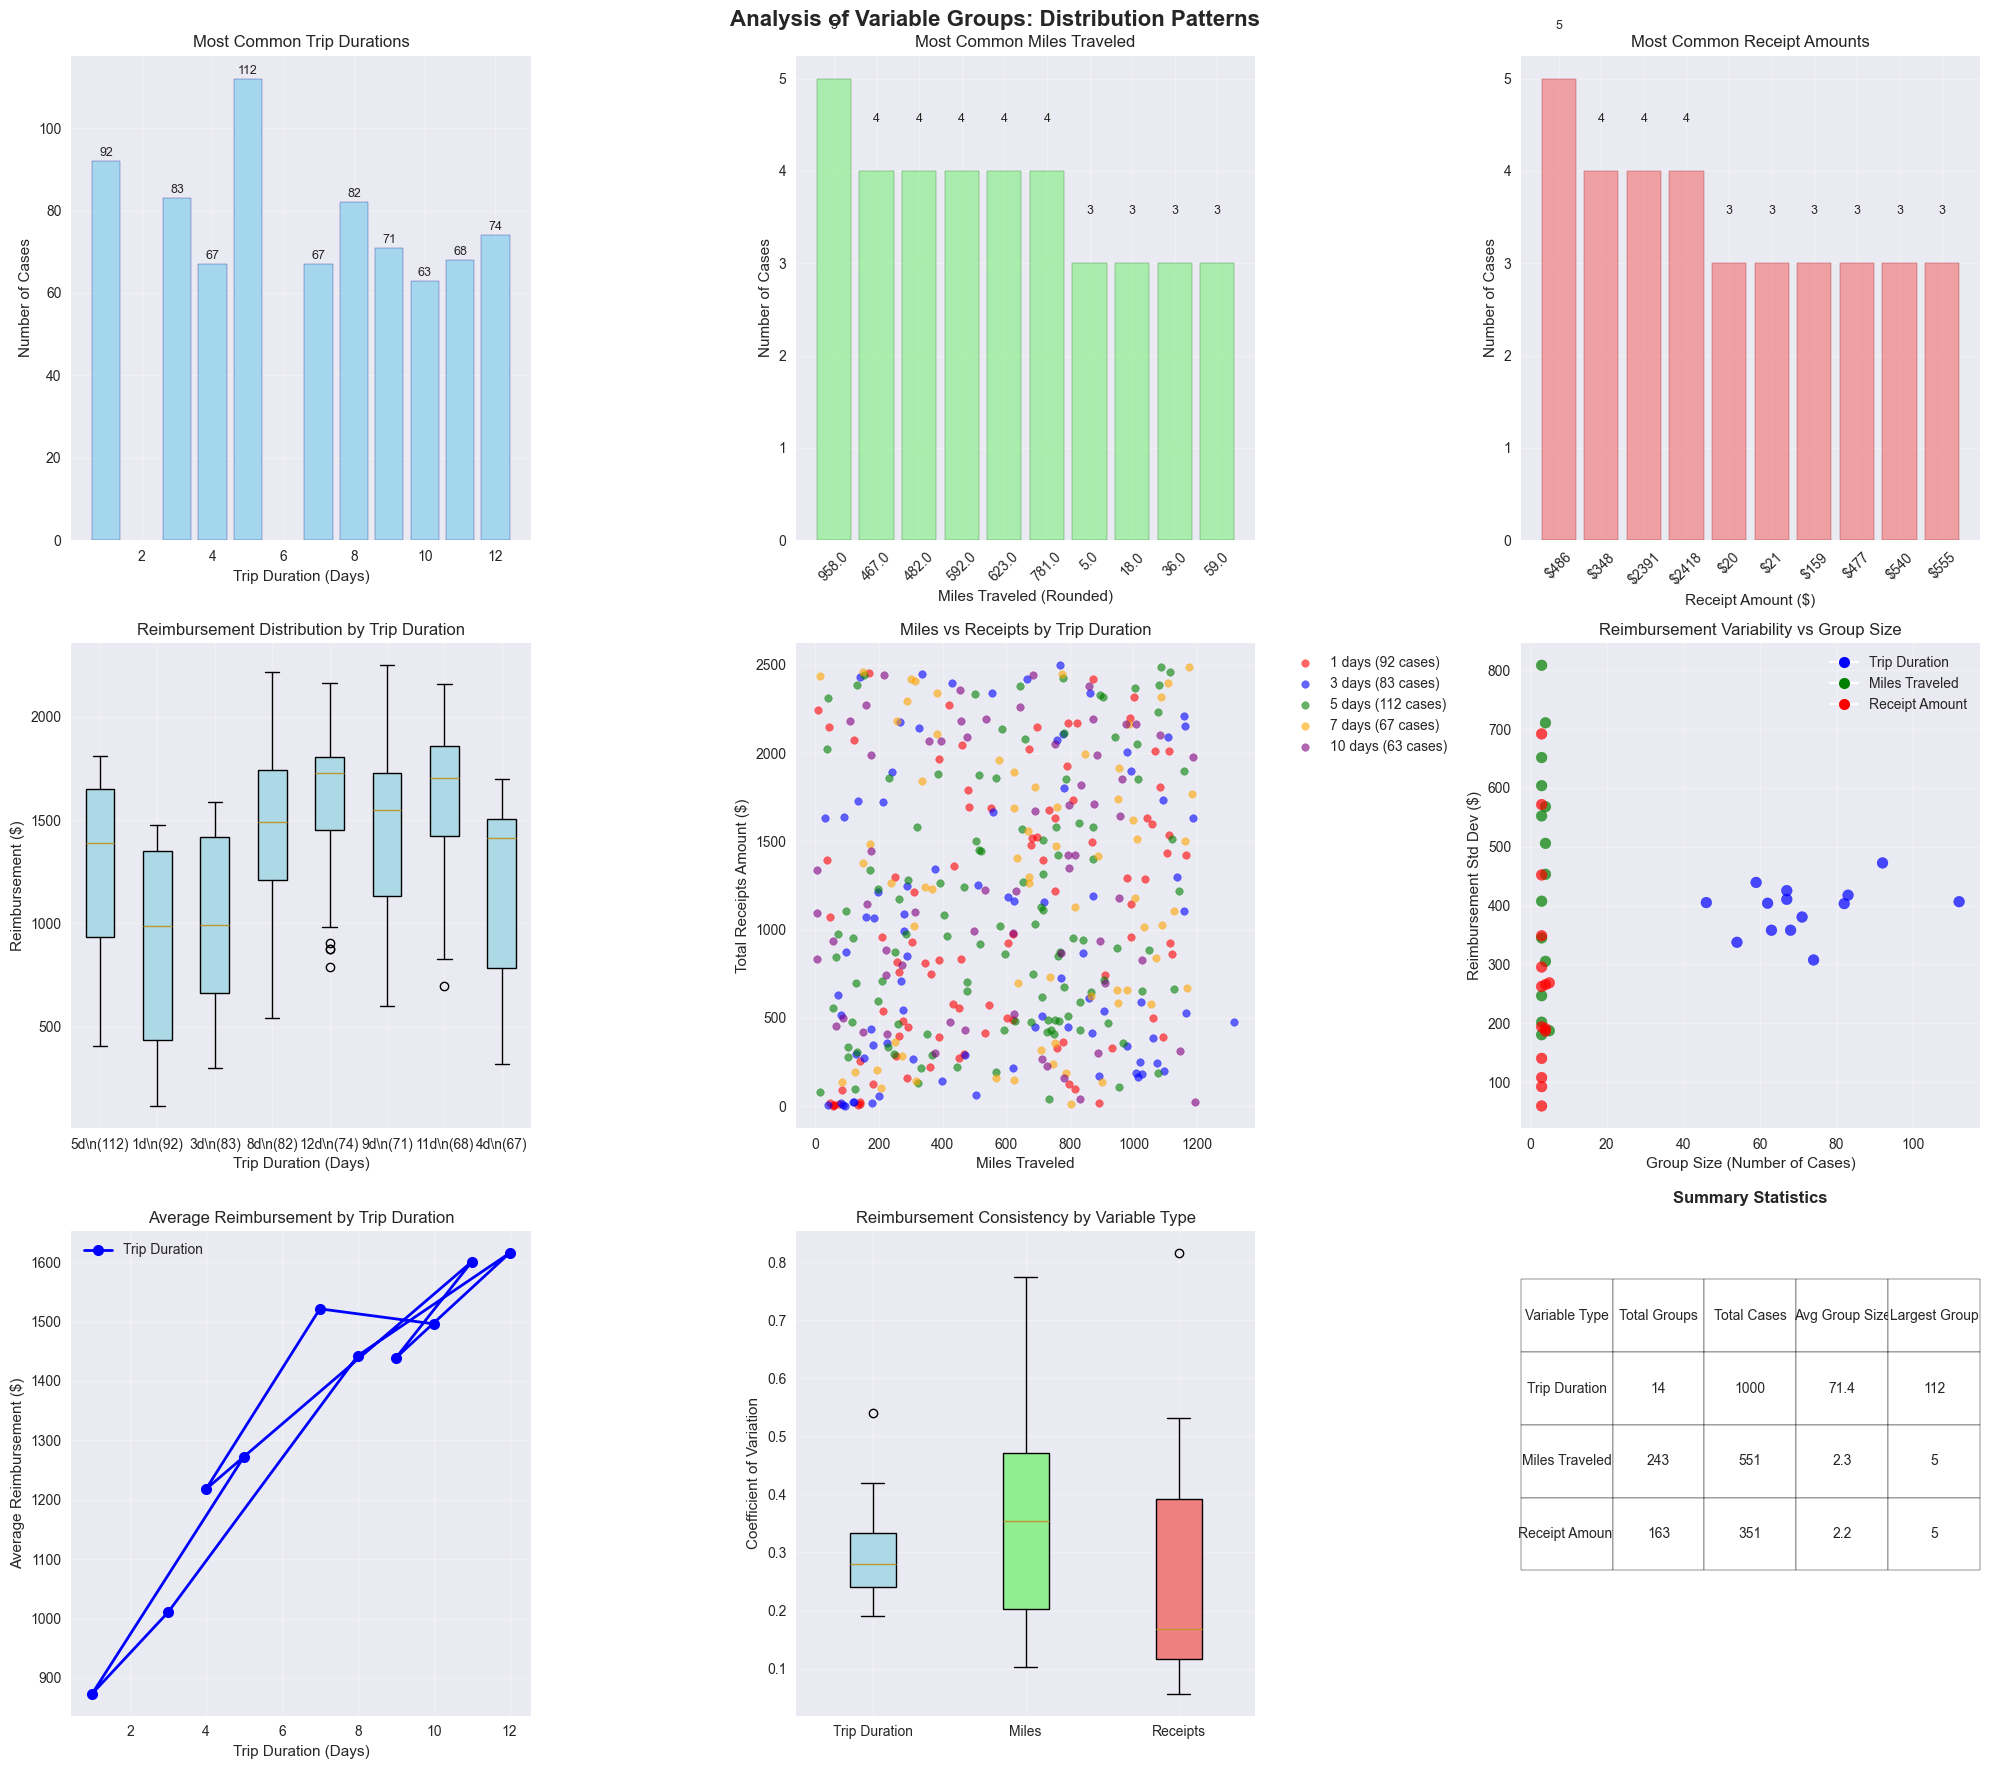

\n=== ANALYSIS SUMMARY ===
Successfully analyzed variable groupings:
• Trip Duration: 14 unique values
• Miles Traveled: 243 unique values
• Receipt Amount: 163 unique values
\nMost common patterns identified and visualized above.


In [52]:
# Comprehensive plotting for variable grouping analysis
print("=== PLOTTING VARIABLE GROUPING ANALYSIS ===")

# Create comprehensive visualizations for the grouping analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Analysis of Variable Groups: Distribution Patterns', fontsize=16, fontweight='bold')

# Plot 1: Trip Duration Groups - Top 10 most common durations
ax1 = axes[0, 0]
top_trip_durations = all_results['trip_duration'][:10]
trip_values = [g['group_value'] for g in top_trip_durations]
trip_counts = [g['count'] for g in top_trip_durations]
bars1 = ax1.bar(trip_values, trip_counts, alpha=0.7, color='skyblue', edgecolor='navy')
ax1.set_xlabel('Trip Duration (Days)')
ax1.set_ylabel('Number of Cases')
ax1.set_title('Most Common Trip Durations')
ax1.grid(True, alpha=0.3)
# Add count labels on bars
for bar, count in zip(bars1, trip_counts):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=9)

# Plot 2: Miles Traveled Groups - Top 10 most common mileages
ax2 = axes[0, 1]
top_miles = all_results['miles_traveled'][:10]
miles_values = [g['group_value'] for g in top_miles]
miles_counts = [g['count'] for g in top_miles]
bars2 = ax2.bar(range(len(miles_values)), miles_counts, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
ax2.set_xlabel('Miles Traveled (Rounded)')
ax2.set_ylabel('Number of Cases')
ax2.set_title('Most Common Miles Traveled')
ax2.set_xticks(range(len(miles_values)))
ax2.set_xticklabels([f'{v:.1f}' for v in miles_values], rotation=45)
ax2.grid(True, alpha=0.3)
# Add count labels on bars
for bar, count in zip(bars2, miles_counts):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=9)

# Plot 3: Receipt Amount Groups - Top 10 most common amounts
ax3 = axes[0, 2]
top_receipts = all_results['total_receipts'][:10]
receipt_values = [g['group_value'] for g in top_receipts]
receipt_counts = [g['count'] for g in top_receipts]
bars3 = ax3.bar(range(len(receipt_values)), receipt_counts, alpha=0.7, color='lightcoral', edgecolor='darkred')
ax3.set_xlabel('Receipt Amount ($)')
ax3.set_ylabel('Number of Cases')
ax3.set_title('Most Common Receipt Amounts')
ax3.set_xticks(range(len(receipt_values)))
ax3.set_xticklabels([f'${v:.0f}' for v in receipt_values], rotation=45)
ax3.grid(True, alpha=0.3)
# Add count labels on bars
for bar, count in zip(bars3, receipt_counts):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=9)

# Plot 4: Reimbursement by Trip Duration (Box plot)
ax4 = axes[1, 0]
trip_reimb_data = []
trip_labels = []
for g in all_results['trip_duration'][:8]:  # Top 8 groups
    # Get the actual data for this group
    if g['group_value'] in public_df['trip_duration_days'].values:
        group_data = public_df[public_df['trip_duration_days'] == g['group_value']]['reimbursement']
        if len(group_data) > 0:
            trip_reimb_data.append(group_data.values)
            trip_labels.append(f"{int(g['group_value'])}d\\n({g['count']})")

if trip_reimb_data:
    bp1 = ax4.boxplot(trip_reimb_data, labels=trip_labels, patch_artist=True)
    for patch in bp1['boxes']:
        patch.set_facecolor('lightblue')
    ax4.set_xlabel('Trip Duration (Days)')
    ax4.set_ylabel('Reimbursement ($)')
    ax4.set_title('Reimbursement Distribution by Trip Duration')
    ax4.grid(True, alpha=0.3)

# Plot 5: Miles vs Receipts for different trip durations
ax5 = axes[1, 1]
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, duration in enumerate([1, 3, 5, 7, 10]):  # Common durations
    duration_data = public_df[public_df['trip_duration_days'] == duration]
    if len(duration_data) > 0:
        ax5.scatter(duration_data['miles_traveled'], duration_data['total_receipts_amount'], 
                   alpha=0.6, s=30, color=colors[i % len(colors)], 
                   label=f'{duration} days ({len(duration_data)} cases)')
ax5.set_xlabel('Miles Traveled')
ax5.set_ylabel('Total Receipts Amount ($)')
ax5.set_title('Miles vs Receipts by Trip Duration')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.grid(True, alpha=0.3)

# Plot 6: Reimbursement variability by group size
ax6 = axes[1, 2]
group_sizes = []
reimb_stds = []
group_types = []
colors_list = []

for result_type, color in [('trip_duration', 'blue'), ('miles_traveled', 'green'), ('total_receipts', 'red')]:
    for g in all_results[result_type][:15]:  # Top 15 groups
        group_sizes.append(g['count'])
        reimb_stds.append(g['reimbursement_std'])
        group_types.append(result_type)
        colors_list.append(color)

scatter = ax6.scatter(group_sizes, reimb_stds, c=colors_list, alpha=0.7, s=60)
ax6.set_xlabel('Group Size (Number of Cases)')
ax6.set_ylabel('Reimbursement Std Dev ($)')
ax6.set_title('Reimbursement Variability vs Group Size')
ax6.grid(True, alpha=0.3)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Trip Duration'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Miles Traveled'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Receipt Amount')]
ax6.legend(handles=legend_elements)

# Plot 7: Average reimbursement by variable value
ax7 = axes[2, 0]
trip_values_plot = [g['group_value'] for g in all_results['trip_duration'][:10]]
trip_reimb_means = [g['reimbursement_mean'] for g in all_results['trip_duration'][:10]]
ax7.plot(trip_values_plot, trip_reimb_means, 'o-', color='blue', linewidth=2, markersize=8, label='Trip Duration')
ax7.set_xlabel('Trip Duration (Days)')
ax7.set_ylabel('Average Reimbursement ($)')
ax7.set_title('Average Reimbursement by Trip Duration')
ax7.grid(True, alpha=0.3)
ax7.legend()

# Plot 8: Coefficient of Variation analysis
ax8 = axes[2, 1]
cv_data = {'Trip Duration': [], 'Miles Traveled': [], 'Receipt Amount': []}
for result_type, label in [('trip_duration', 'Trip Duration'), ('miles_traveled', 'Miles Traveled'), ('total_receipts', 'Receipt Amount')]:
    for g in all_results[result_type][:20]:  # Top 20 groups
        if g['reimbursement_mean'] > 0:
            cv = g['reimbursement_std'] / g['reimbursement_mean']
            cv_data[label].append(cv)

# Create box plot for CV
cv_values = [cv_data['Trip Duration'], cv_data['Miles Traveled'], cv_data['Receipt Amount']]
bp2 = ax8.boxplot(cv_values, labels=['Trip Duration', 'Miles', 'Receipts'], patch_artist=True)
colors_cv = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp2['boxes'], colors_cv):
    patch.set_facecolor(color)
ax8.set_ylabel('Coefficient of Variation')
ax8.set_title('Reimbursement Consistency by Variable Type')
ax8.grid(True, alpha=0.3)

# Plot 9: Summary statistics table
ax9 = axes[2, 2]
ax9.axis('off')

# Create summary table
summary_data = []
for result_type, label in [('trip_duration', 'Trip Duration'), ('miles_traveled', 'Miles Traveled'), ('total_receipts', 'Receipt Amount')]:
    results = all_results[result_type]
    total_groups = len(results)
    total_cases = sum(g['count'] for g in results)
    avg_group_size = total_cases / total_groups if total_groups > 0 else 0
    largest_group = max(g['count'] for g in results) if results else 0
    
    summary_data.append([label, total_groups, total_cases, f"{avg_group_size:.1f}", largest_group])

table = ax9.table(cellText=summary_data,
                  colLabels=['Variable Type', 'Total Groups', 'Total Cases', 'Avg Group Size', 'Largest Group'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0.3, 1, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax9.set_title('Summary Statistics', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\\n=== ANALYSIS SUMMARY ===")
print(f"Successfully analyzed variable groupings:")
print(f"• Trip Duration: {len(all_results['trip_duration'])} unique values")
print(f"• Miles Traveled: {len(all_results['miles_traveled'])} unique values") 
print(f"• Receipt Amount: {len(all_results['total_receipts'])} unique values")
print(f"\\nMost common patterns identified and visualized above.")
